In [25]:
%matplotlib inline

import numpy as np
import pandas as pd

import os
import random
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter, HourLocator, DayLocator
import matplotlib.ticker as ticker
from datetime import datetime, timedelta
from collections import defaultdict
import sys
import json
import importlib

sys.path.insert(0, '../code/')
import helper_functions

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

import math

## Reading the pickle file

In [3]:
start = time.time()

os.chdir("../data/")

print(os.getcwd())

# updates_dic_unique_Indonesia.json
# updates_dic_Indonesia.json
with open('updates_dic_unique_Indonesia.json', 'rb') as fp:
    count_table = json.load(fp)
    
print('time loading:', time.time() - start)

/Users/pmoriano/Desktop/bgp-burstiness/data
time loading: 613.8248579502106


In [4]:
list(count_table['route-views.saopaulo'].keys())

['2014-03-30 23:33:07',
 '2014-04-03 02:53:04',
 '2014-04-04 12:54:13',
 '2014-04-02 01:44:54',
 '2014-04-03 11:39:19',
 '2014-03-31 05:26:39',
 '2014-04-01 23:37:07',
 '2014-04-01 12:40:22',
 '2014-04-02 20:30:56',
 '2014-04-02 20:30:57',
 '2014-04-02 20:30:54',
 '2014-04-02 20:30:55',
 '2014-04-02 20:30:52',
 '2014-04-02 20:30:53',
 '2014-04-02 20:30:50',
 '2014-04-02 20:30:51',
 '2014-04-04 22:47:11',
 '2014-04-02 20:30:58',
 '2014-04-02 20:30:59',
 '2014-04-01 21:22:09',
 '2014-03-30 23:33:00',
 '2014-04-04 09:28:29',
 '2014-04-04 06:35:04',
 '2014-04-04 06:35:05',
 '2014-04-04 06:35:06',
 '2014-04-04 06:35:07',
 '2014-04-04 06:35:00',
 '2014-04-04 06:35:01',
 '2014-04-04 06:35:02',
 '2014-04-04 06:35:03',
 '2014-04-01 23:37:09',
 '2014-04-04 06:35:08',
 '2014-04-04 06:35:09',
 '2014-03-30 23:33:03',
 '2014-04-04 09:28:28',
 '2014-04-04 22:47:13',
 '2014-03-31 18:13:01',
 '2014-04-01 21:22:07',
 '2014-03-30 23:33:02',
 '2014-04-02 12:40:49',
 '2014-04-02 12:40:48',
 '2014-04-01 23:

# Announcements

## Indosat

In [5]:
# To get the data coming form the hijacker

start = time.time()

dic = defaultdict(list)
asn_of_interest = '4761'

for key_collector in sorted(count_table):
    # print key_collector
    for key_date in sorted(count_table[key_collector]):
        if asn_of_interest in count_table[key_collector][key_date]: 
            dic[key_collector].append([datetime.strptime(key_date, '%Y-%m-%d %H:%M:%S'), count_table[key_collector][key_date][asn_of_interest][0], count_table[key_collector][key_date][asn_of_interest][1]])
            
print('time loading:', time.time() - start)

time loading: 84.11469888687134


## Get a sense of the structure of the data

In [6]:
print(list(dic.keys()))
collector = 'route-views.linx'
print(dic[collector][:2])
print(dic[collector][-2:])

['route-views.eqix', 'route-views.isc', 'route-views.jinx', 'route-views.linx', 'route-views.nwax', 'route-views.saopaulo', 'route-views.soxrs', 'route-views.sydney', 'route-views.telxatl', 'route-views.wide', 'route-views2', 'route-views3', 'route-views4', 'route-views6']
[[datetime.datetime(2014, 3, 30, 16, 13, 4), 1, 0], [datetime.datetime(2014, 3, 30, 16, 13, 8), 1, 0]]
[[datetime.datetime(2014, 4, 5, 19, 2, 10), 1, 0], [datetime.datetime(2014, 4, 5, 20, 52, 15), 51, 0]]


## Ranking based on number of feeders

In [7]:
# Load the dictionary of knowledge
with open("dic_feeders_evolution_Indonesia.p", "rb") as fp:
    evolution_dic = pickle.load(fp)

## Ranking based on the number of Routers

In [8]:
# Time at which the ranking is done
reference_time = "2014-03-31 00:00:00"
new_dic = {}

for collector in evolution_dic:
    new_dic[collector] = len(set(np.array(evolution_dic[collector][reference_time])[:,1])) # ASes are index 0, routers are 1
    
number_of_feeders = sorted(new_dic, key=lambda k: new_dic[k], reverse=True) # Sort collectors in increasing order
number_of_feeders = ['route-views' + feed if (feed == '2' or feed == '3' or feed == '4' or feed == '6') else 'route-views.' + feed for feed in number_of_feeders]
print(number_of_feeders)

['route-views.linx', 'route-views.saopaulo', 'route-views4', 'route-views2', 'route-views.eqix', 'route-views6', 'route-views.isc', 'route-views3', 'route-views.sydney', 'route-views.jinx', 'route-views.telxatl', 'route-views.nwax', 'route-views.wide', 'route-views.perth', 'route-views.kixp', 'route-views.soxrs']


## Predict Based on LSTM

In [9]:
importlib.reload(helper_functions)

# fix random seed for reproducibility
np.random.seed(7)

def LSTM_predictor(x, y):
    """
    Time series forecasting based on LSTM
    @param x: times (datetime)
    @param y: values (float)
    @out output: predictions (train + test) (float)
    """
    # Select the end of the training data
    end_of_training = x[0] + timedelta(days=1)
    # Check when the position has pass exactly one day of observations
    
    boolean_array = x < end_of_training
    date_thereshold = np.where(boolean_array==False)[0][0]
    
    dataset = y
    # transform time series data into format supported by Keras
    dataset = dataset.reshape(len(dataset), 1)
    # print(len(dataset))

    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)
    
    # split into train and test sets
    train_size = int(date_thereshold) # len(y)*0.01
    test_size = len(dataset) - train_size
    train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
    # print("original sizes: ", train_size, test_size)
    
    # reshape into X=t and Y=t+1
    time_steps = 1
    trainX, trainY = helper_functions.create_dataset(train, time_steps)
    testX, testY = helper_functions.create_dataset(test, time_steps)
    
    # print("shapes: ", trainX.shape[0], trainX.shape[1])
            
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(time_steps, 1)))
    # model.add(LSTM(50, activation="relu", return_sequences=True, input_shape=(time_steps, n_features)))
    # model.add(LSTM(50, activation="relu"))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=0) # careful with batch_size, 1, trainX.shape[0]
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    
    #print(np.concatenate((trainY[0], testY[0]), axis=None))
    #print(len(trainPredict[:,0]), len(testPredict[:,0]))
    output = np.concatenate((trainPredict[:,0], testPredict[:,0]), axis=None)

    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
#     # shift train predictions for plotting
#     trainPredictPlot = np.empty_like(dataset)
#     trainPredictPlot[:, :] = np.nan
#     trainPredictPlot[time_steps:len(trainPredict)+time_steps, :] = trainPredict
#     # shift test predictions for plotting
#     testPredictPlot = np.empty_like(dataset)
#     testPredictPlot[:, :] = np.nan
#     testPredictPlot[len(trainPredict)+(time_steps*2)+1:len(dataset)-1, :] = testPredict
#     # plot baseline and predictions
#     plt.plot(x, scaler.inverse_transform(dataset))
#     plt.plot(x, trainPredictPlot)
#     plt.plot(x, testPredictPlot)
#     plt.show()

    #print(len(output))
    
    return(output)
    
    
collector = "route-views2"  
LSTM_predictor(np.array(dic[collector])[:,0], np.array(dic[collector])[:,1])

Train Score: 37.11 RMSE
Test Score: 138.52 RMSE


array([13.707717, 14.200464, 13.707717, ..., 12.227841, 14.270835,
       -5.998117], dtype=float32)

## Top Four

route-views.linx
rmse:  81.36542553155188
route-views.saopaulo
rmse:  105.87285366470194
route-views4
rmse:  95.83190200277073
route-views2
rmse:  115.33179035750823


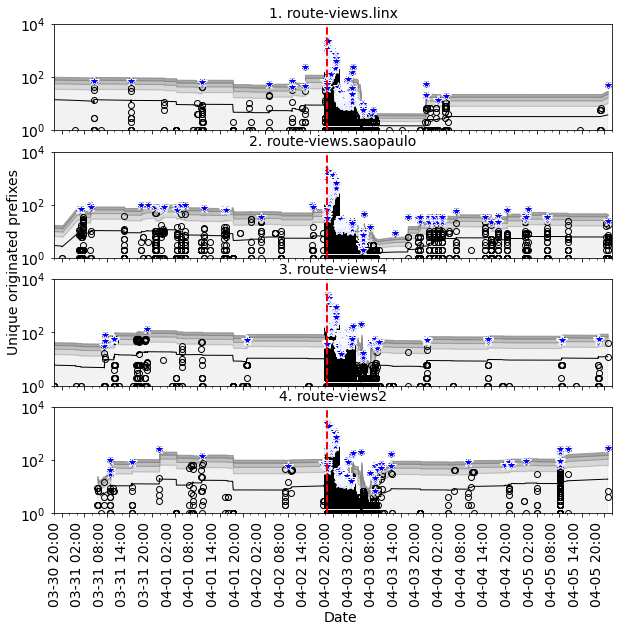

In [13]:
list_collectors = number_of_feeders[:4]

row = len(list_collectors)
col = 1

fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.2, wspace=0.05)

count = 0

for collector in list_collectors: #final_dic:
    
    print(collector)

#     index_x = int(count/2)
#     if count % 2 == 0:
#         index_y = 0
#     else:
#         index_y = 1

    # print index_x, index_y
    # print count
    ax = axes[count] 
    ax.set_title(str(count + 1) + '. ' + collector, fontsize=14) 
        
    if dic[collector] != []:

        x = np.array(dic[collector])[:,0]
        y = np.array(dic[collector])[:,1]

        ax.plot(x, y, linestyle="None", marker="o", mfc="None", markeredgecolor="black", label="Data")
        ax.set_yscale("log")
        
        # Convert data in time series for calculations
        s = pd.Series(y, index=x)

        window_length = 200
        mean = s.ewm(span=window_length, min_periods=1).mean()
        sd = s.ewm(span=window_length, min_periods=1).std()
        
        array_means = mean.values
        array_stds = sd.values
        
        ax.plot(x, array_means, color="black", linewidth=1.0)
        print('rmse: ', np.sqrt(mean_squared_error(y, array_means)))
        
        # Band scale
        sigma = 1.0
        ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="gray", alpha=0.10)

        ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="gray", alpha=0.30)
        # ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="gray", alpha=0.30)

        ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="gray", alpha=0.50)
        # ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="gray", alpha=0.50)

        ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="gray", alpha=0.70)
        # ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="gray", alpha=0.70)

        anomalies_index = (y >= (mean + 2*sigma*sd)).values
    
        # To avaoid null cases
        if len(x[anomalies_index]) > 0:
            ax.plot(x[anomalies_index], y[anomalies_index], linestyle="None", marker="*", mfc="blue", markeredgecolor="white", markersize=10)  


    # Assign font size
    for label in ([ax.xaxis.label, ax.yaxis.label]):
        label.set_fontsize(14)

    # x axis
    for tl in ax.get_xticklabels():
        tl.set_fontsize(14)

    # y axis
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    # Change ticks space
    ax.tick_params(axis="both", which="major", pad=5)  

    ax.set_xlim([datetime(2014, 3, 30, 18, 0, 0), datetime(2014, 4, 5, 22, 0, 0)])
    ax.set_ylim([10**0, 10**4])
    # ax.set_ylim(bottom=1)
    # ax.set_ylim(auto=True)
    

    ax.xaxis.set_major_locator(HourLocator(byhour=None, interval=6, tz=None))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
    ax.xaxis.set_minor_locator(HourLocator(byhour=None, interval=2, tz=None))

    ax.axvline(datetime(2014, 4, 2, 18, 26, 0), color='red', linewidth=2.0, linestyle='--')

    count += 1

fig.autofmt_xdate(rotation=90) 
    

fig.text(0.5, 0.055, 'Date', va="center", rotation="horizontal", fontsize=14)
fig.text(0.06, 0.55, 'Unique originated prefixes', va="center", rotation="vertical", fontsize=14)

# fit subplots and save fig
size = 10
fig.set_size_inches(w=size, h=1.0*size) # size/1.618

if len(list_collectors) % 2 != 0:
    ax = axes[int(len(list_collectors)/2), 1]
    ax.set_visible(False)
    
    
plt.show()

## Top Four LSTM

route-views.linx
Train Score: 20.74 RMSE
Test Score: 100.04 RMSE
route-views.saopaulo
Train Score: 16.48 RMSE
Test Score: 130.05 RMSE
route-views4
Train Score: 21.28 RMSE
Test Score: 106.35 RMSE
route-views2
Train Score: 37.18 RMSE
Test Score: 132.18 RMSE


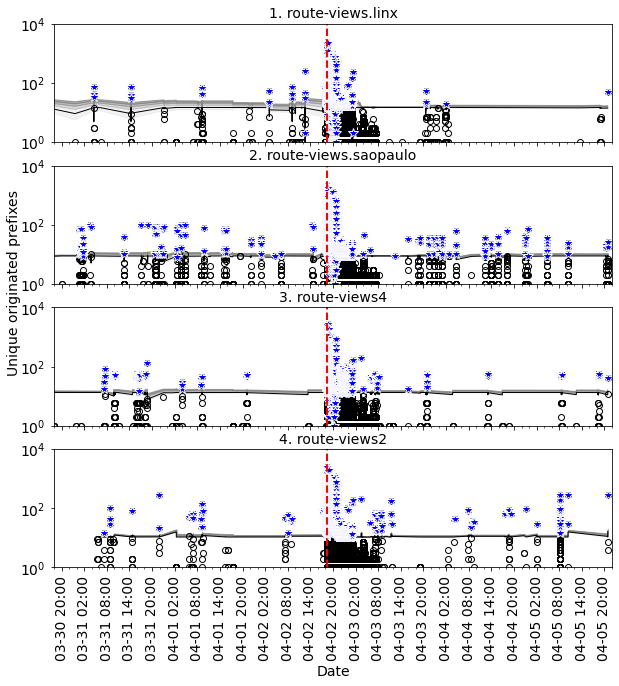

In [14]:
list_collectors = number_of_feeders[:4]

row = len(list_collectors)
col = 1

fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.2, wspace=0.05)

count = 0

for collector in list_collectors: #final_dic:
    
    print(collector)

    ax = axes[count] 
    ax.set_title(str(count + 1) + '. ' + collector, fontsize=14) 
        
    if dic[collector] != []:

        x = np.array(dic[collector])[:,0]
        y = np.array(dic[collector])[:,1]
        
        ax.plot(x, y, linestyle="None", marker="o", mfc="None", markeredgecolor="black", label="Data")
        ax.set_yscale("log")
                
        # Based on LSTM model   
        LSTM_prediction = LSTM_predictor(x, y)
        x = x[4:]
        y = y[4:]
        
        # print('rmse_LSTM: ', np.sqrt(mean_squared_error(y, LSTM_prediction)))
        
        s = pd.Series(LSTM_prediction, index=x)

        window_length = 200
        #mean = s.ewm(span=window_length, min_periods=1).mean()
        sd = s.ewm(span=window_length, min_periods=1).std()
        
        array_means = LSTM_prediction
        array_stds = sd.values
        
        ax.plot(x, array_means, color="black", linewidth=1.0)
        
        # Band scale
        sigma = 1.0
        ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="gray", alpha=0.10)

        ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="gray", alpha=0.30)
        # ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="gray", alpha=0.30)

        ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="gray", alpha=0.50)
        # ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="gray", alpha=0.50)

        ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="gray", alpha=0.70)
        # ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="gray", alpha=0.70)

        anomalies_index = (y >= (LSTM_prediction + 2*sigma*sd)).values
    
        # To avoid null cases
        if len(x[anomalies_index]) > 0:
            ax.plot(x[anomalies_index], y[anomalies_index], linestyle="None", marker="*", mfc="blue", markeredgecolor="white", markersize=10)  

    # Assign font size
    for label in ([ax.xaxis.label, ax.yaxis.label]):
        label.set_fontsize(14)

    # x axis
    for tl in ax.get_xticklabels():
        tl.set_fontsize(14)
        tl.set_rotation(90)

    # y axis
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    # Change ticks space
    ax.tick_params(axis="both", which="major", pad=5)  

    # Include a grid
    # ax.xaxis.grid()
    # ax.yaxis.grid()

    # Setup the limit
    ax.set_xlim([datetime(2014, 3, 30, 18, 0, 0), datetime(2014, 4, 5, 22, 0, 0)])
    ax.set_ylim([10**0, 10**4])
    #ax.set_ylim(auto=True)
    #ax.set_ylim(bottom=1)
    
    
    ax.xaxis.set_major_locator(HourLocator(byhour=None, interval=6, tz=None))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
    ax.xaxis.set_minor_locator(HourLocator(byhour=None, interval=2, tz=None))

    
    # Draw ground truth
    
    ax.axvline(datetime(2014, 4, 2, 18, 26, 0), color='red', linewidth=2.0, linestyle='--')
    # ax.axvline(datetime(2014, 4, 2, 21, 26, 0), color='red', linewidth=2.0, linestyle='--')
    
#     if collector in ground_truth_dic:
#         for line in ground_truth_dic[collector]:
#             ax.axvline(line, color='red', linewidth=2.0, linestyle='--')

    count += 1

# plt.xticks(rotation=90)
# fig.autofmt_xdate(rotation=90) 
    
# ax.set_xlabel("Date", labelpad=5)  

fig.text(0.49, -0.020, 'Date', va="center", rotation="horizontal", fontsize=14) # 0.50 and 0.055
fig.text(0.06, 0.52, 'Unique originated prefixes', va="center", rotation="vertical", fontsize=14) # 0.06 0.55

# fit subplots and save fig
size = 10 # 10, 3.5
fig.set_size_inches(w=size, h=1.0*size) # size/1.618

if len(list_collectors) % 2 != 0:
    ax = axes[int(len(list_collectors)/2), 1]
    ax.set_visible(False)
    
    
plt.show()

## Remaining collectors

route-views.eqix
rmse:  79.44192616883043
route-views6
rmse:  1.361191238379709
route-views.isc
rmse:  52.72065841648046
route-views3
rmse:  56.22803762009604
route-views.sydney
rmse:  61.50825658655571
route-views.jinx
rmse:  135.32747070601985
route-views.telxatl
rmse:  72.63730763019772
route-views.nwax
rmse:  92.43709638388844
route-views.wide
rmse:  113.04126396493663
route-views.perth
route-views.kixp
route-views.soxrs
rmse:  0.0


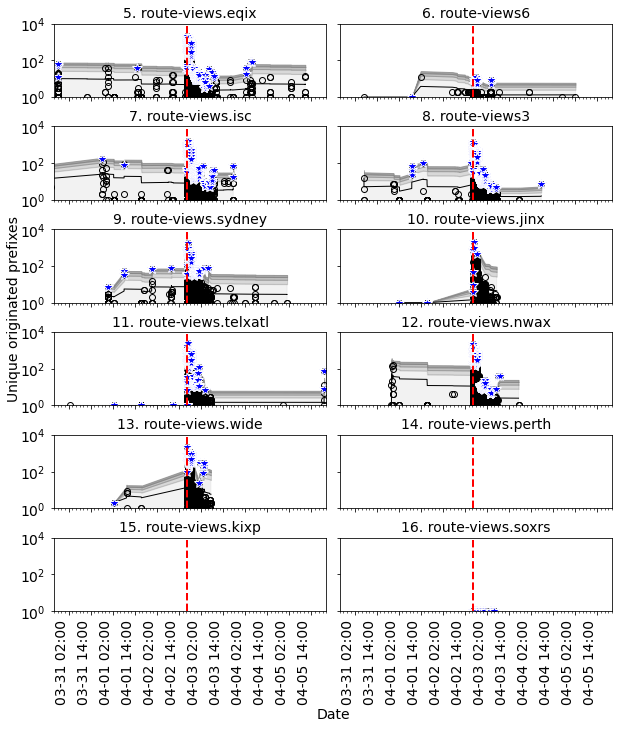

In [16]:
list_collectors = number_of_feeders[4:]

if len(list_collectors) % 2 != 0: # Odd
    row = int(len(list_collectors)/2) + 1
else: # Even
    row = int(len(list_collectors)/2)
col = 2

fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.4, wspace=0.05)

count = 0

for collector in list_collectors: #final_dic:
    
    print(collector)

    index_x = int(count/2)
    if count % 2 == 0:
        index_y = 0
    else:
        index_y = 1

    ax = axes[index_x, index_y] 
    ax.set_title(str(count + 5) + '. ' + collector, fontsize=14) 
        
    if dic[collector] != []:

        x = np.array(dic[collector])[:,0]
        y = np.array(dic[collector])[:,1]

        ax.plot(x, y, linestyle="None", marker="o", mfc="None", markeredgecolor="black", label="Data")
        ax.set_yscale("log")
        
        # Conver data in time series for calculations
        s = pd.Series(y, index=x)

        window_length = 200
        mean = s.ewm(span=window_length, min_periods=1).mean()
        sd = s.ewm(span=window_length, min_periods=1).std()
        
        array_means = mean.values
        array_stds = sd.values
        
        ax.plot(x, array_means, color="black", linewidth=1.0)
        print('rmse: ', np.sqrt(mean_squared_error(y, array_means)))
        
        # Band scale
        sigma = 1.0
        ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="gray", alpha=0.10)

        ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="gray", alpha=0.30)
        # ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="gray", alpha=0.30)

        ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="gray", alpha=0.50)
        # ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="gray", alpha=0.50)

        ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="gray", alpha=0.70)
        # ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="gray", alpha=0.70)

        anomalies_index = (y >= (mean + 2*sigma*sd)).values
        
        # To avaoid null cases
        if len(x[anomalies_index]) > 0:
            ax.plot(x[anomalies_index], y[anomalies_index], linestyle="None", marker="*", mfc="blue", markeredgecolor="white", markersize=10)  

            
    # Assign font size

    # Assign font size
    for label in ([ax.xaxis.label, ax.yaxis.label]):
        label.set_fontsize(14)

    # x axis
    for tl in ax.get_xticklabels():
        tl.set_fontsize(14)

    # y axis
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    # Change ticks space
    ax.tick_params(axis="both", which="major", pad=5)  

    # Setup the limit
    ax.set_xlim([datetime(2014, 3, 30, 18, 0, 0), datetime(2014, 4, 5, 22, 0, 0)])
    ax.set_ylim([10**0, 10**4])
    #ax.set_ylim(auto=True)
    #ax.set_ylim(bottom=1)

    ax.xaxis.set_major_locator(HourLocator(byhour=None, interval=12, tz=None))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
    ax.xaxis.set_minor_locator(HourLocator(byhour=None, interval=2, tz=None))
   
    ax.axvline(datetime(2014, 4, 2, 18, 26, 0), color='red', linewidth=2.0, linestyle='--')


    count += 1

plt.setp(ax.xaxis.get_majorticklabels(), ha="right")
fig.autofmt_xdate(rotation=90) 

fig.text(0.49, 0.08, 'Date', va="center", rotation="horizontal", fontsize=14)
fig.text(0.06, 0.55, 'Unique originated prefixes', va="center", rotation="vertical", fontsize=14)

# fit subplots and save fig
size = 10
fig.set_size_inches(w=size, h=1.2*size) # size/1.618

if len(list_collectors) % 2 != 0:
    ax = axes[int(len(list_collectors)/2), 1]
    ax.set_visible(False)
        
plt.show()

## Remaining Collectors LSTM

route-views.eqix
Train Score: 16.34 RMSE
Test Score: 85.09 RMSE
route-views6
route-views.isc
Train Score: 18.05 RMSE
Test Score: 58.54 RMSE
route-views3
Train Score: 2.27 RMSE
Test Score: 62.99 RMSE
route-views.sydney
Train Score: 15.42 RMSE
Test Score: 64.07 RMSE
route-views.jinx
Train Score: 0.00 RMSE
Test Score: 140.38 RMSE
route-views.telxatl
Train Score: 0.00 RMSE
Test Score: 76.16 RMSE
route-views.nwax
Train Score: 38.57 RMSE
Test Score: 100.64 RMSE
route-views.wide
Train Score: 3.19 RMSE
Test Score: 121.16 RMSE
route-views.perth
route-views.kixp
route-views.soxrs


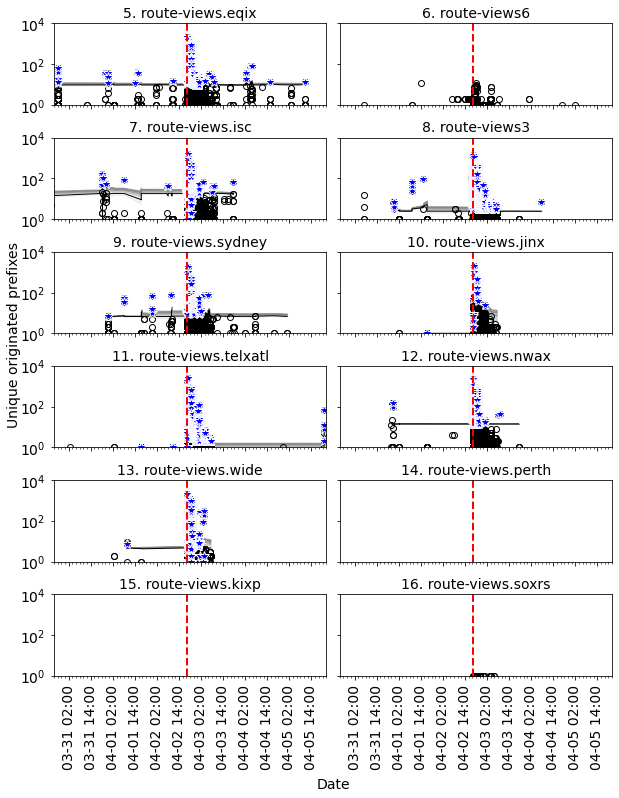

In [17]:
list_collectors = number_of_feeders[4:]

if len(list_collectors) % 2 != 0: # Odd
    row = int(len(list_collectors)/2) + 1
else: # Even
    row = int(len(list_collectors)/2)
col = 2

fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.4, wspace=0.05)

count = 0

for collector in list_collectors: #final_dic:
    
    print(collector)

    index_x = int(count/2)
    if count % 2 == 0:
        index_y = 0
    else:
        index_y = 1

    # print index_x, index_y
    # print count
    ax = axes[index_x, index_y] 
    ax.set_title(str(count + 5) + '. ' + collector, fontsize=14) 
        
    if dic[collector] != []:

        x = np.array(dic[collector])[:,0]
        y = np.array(dic[collector])[:,1]

        ax.plot(x, y, linestyle="None", marker="o", mfc="None", markeredgecolor="black", label="Data")
        ax.set_yscale("log")
        
        # Based on LSTM model   
            
        try: 
            LSTM_prediction = LSTM_predictor(x, y)
            x = x[4:]
            y = y[4:]

            # print('rmse_LSTM: ', np.sqrt(mean_squared_error(y, LSTM_prediction)))

            s = pd.Series(LSTM_prediction, index=x)

            window_length = 200
            #mean = s.ewm(span=window_length, min_periods=1).mean()
            sd = s.ewm(span=window_length, min_periods=1).std()

            array_means = LSTM_prediction
            array_stds = sd.values

            ax.plot(x, array_means, color="black", linewidth=1.0)

            # Band scale
            sigma = 1.0
            ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="gray", alpha=0.10)

            ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="gray", alpha=0.30)
            # ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="gray", alpha=0.30)

            ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="gray", alpha=0.50)
            # ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="gray", alpha=0.50)

            ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="gray", alpha=0.70)
            # ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="gray", alpha=0.70)

            anomalies_index = (y >= (LSTM_prediction + 2*sigma*sd)).values

            # To avoid null cases
            if len(x[anomalies_index]) > 0:
                ax.plot(x[anomalies_index], y[anomalies_index], linestyle="None", marker="*", mfc="blue", markeredgecolor="white", markersize=10)  
        except:
            None

    # Assign font size
    for label in ([ax.xaxis.label, ax.yaxis.label]):
        label.set_fontsize(14)

    # x axis
    for tl in ax.get_xticklabels():
        tl.set_fontsize(14)
        tl.set_rotation(90)

    # y axis
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    # Change ticks space
    ax.tick_params(axis="both", which="major", pad=5)  

    # Include a grid
    # ax.xaxis.grid()
    # ax.yaxis.grid()

    # Setup the limit
    ax.set_xlim([datetime(2014, 3, 30, 18, 0, 0), datetime(2014, 4, 5, 22, 0, 0)])
    ax.set_ylim([10**0, 10**4])
    #ax.set_ylim(auto=True)
    #ax.set_ylim(bottom=1)

    ax.xaxis.set_major_locator(HourLocator(byhour=None, interval=12, tz=None))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
    ax.xaxis.set_minor_locator(HourLocator(byhour=None, interval=2, tz=None))   

    # Draw groudth truth
    
    ax.axvline(datetime(2014, 4, 2, 18, 26, 0), color='red', linewidth=2.0, linestyle='--')
    # ax.axvline(datetime(2014, 4, 2, 21, 26, 0), color='red', linewidth=2.0, linestyle='--')
    
#     if collector in ground_truth_dic:
#         for line in ground_truth_dic[collector]:
#             ax.axvline(line, color='red', linewidth=2.0, linestyle='--')


    count += 1


# fig.autofmt_xdate(rotation=90) 
# plt.setp(ax.xaxis.get_majorticklabels(), ha="right")


# ax.set_xlabel("Date", labelpad=5)  

fig.text(0.49, 0.00, 'Date', va="center", rotation="horizontal", fontsize=14)
fig.text(0.06, 0.52, 'Unique originated prefixes', va="center", rotation="vertical", fontsize=14)


# fit subplots and save fig
size = 10
fig.set_size_inches(w=size, h=1.2*size) # size/1.618

if len(list_collectors) % 2 != 0:
    ax = axes[int(len(list_collectors)/2), 1]
    ax.set_visible(False)
    

plt.show()

## Q Series for Top Four

route-views.linx
rmse:  21.837948810576336
route-views.saopaulo
rmse:  20.850719746673388
route-views4
rmse:  20.7200921740908
route-views2
rmse:  19.637894910300634


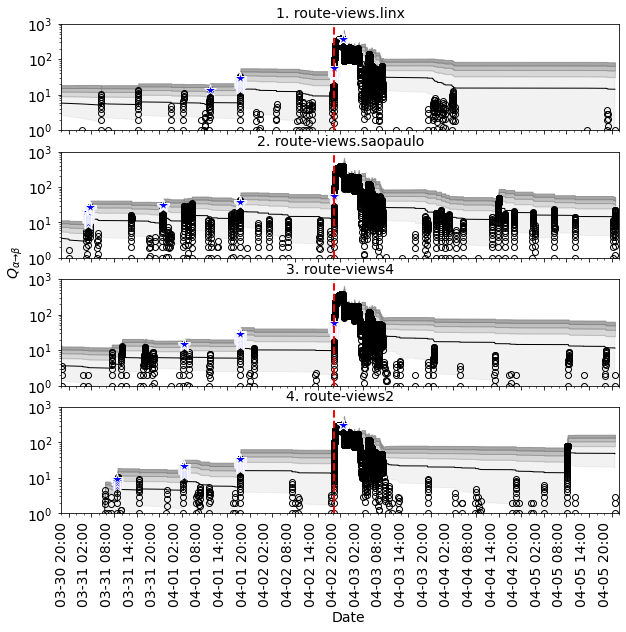

In [19]:
list_collectors = number_of_feeders[:4]

row = len(list_collectors)
col = 1

fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.2, wspace=0.05)

count = 0

for collector in list_collectors: #final_dic:
    
    print(collector)

    # print index_x, index_y
    ax = axes[count]
    ax.set_title(str(count + 1) + '. ' + collector, fontsize=14) 
    
    if dic[collector] != []:

        time_array = np.array(dic[collector])[:,0]

        q = 0
        r = 1/300 # 0.05, 0.01, 1/300 + 0.0033
        q_array = []
        delta_array = []

        for index in range(1, len(time_array)):
            delta = (time_array[index] - time_array[index-1]).seconds
            # print delta
            delta_array.append(delta)
            exponential_term = (2**(-r*delta))*q
            q = 1 + exponential_term
            q_array.append(q)

        delta_array = np.array(delta_array)
        # print np.max(delta_array), np.min(delta_array)

        q_array = np.array(q_array)
        # print np.max(q_array), np.min(q_array)


        # print len(time_array[1:])
        s = pd.Series(q_array, index=time_array[1:])
        
        window_length = 200
        mean = s.ewm(span=window_length, min_periods=1).mean()
        sd = s.ewm(span=window_length, min_periods=1).std()

        x = s.index.to_pydatetime()
        y = s.values

        array_means = mean.values
        array_stds = sd.values

        #ax.plot(x, y, color='black')
        ax.plot(x, y, linestyle="None", marker="o", mfc="None", markeredgecolor="black")
        ax.set_yscale("log")
        # ax.plot(x, y, linestyle="None", marker="o", mfc="None", markeredgecolor="black", markersize=3)
        # ax.plot(x, array_means, color='blue', linewidth=1.5)
        
        ax.plot(x, array_means, color="black", linewidth=1.0)
        print('rmse: ', np.sqrt(mean_squared_error(y, array_means)))

        # Band scale
        sigma = 1.0
        ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="gray", alpha=0.10)

        ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="gray", alpha=0.30)
        # ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="gray", alpha=0.30)

        ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="gray", alpha=0.50)
        # ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="gray", alpha=0.50)

        ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="gray", alpha=0.70)
        # ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="gray", alpha=0.70)

        anomalies_index = y >= (mean + 2*sigma*sd)
        # print 'stars: ', x[anomalies_index], y[anomalies_index]
        ax.plot(x[anomalies_index], y[anomalies_index], linestyle="None", marker="*", mfc="blue", markeredgecolor="white", markersize=12)  
        
        
        # Assign font size
        for label in ([ax.xaxis.label, ax.yaxis.label]):
            label.set_fontsize(14)

        # x axis
        for tl in ax.get_xticklabels():
            tl.set_fontsize(14)

        # y axis
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)

        # Change ticks space
        ax.tick_params(axis="both", which="major", pad=5)  

        # Setup the limit
        ax.set_xlim([datetime(2014, 3, 30, 18, 0, 0), datetime(2014, 4, 5, 22, 0, 0)])
        ax.set_ylim([10**0, 10**3])
        #ax.set_ylim(auto=True)
        #ax.set_ylim(bottom=1)

        ax.xaxis.set_major_locator(HourLocator(byhour=None, interval=6, tz=None))
        ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
        ax.xaxis.set_minor_locator(HourLocator(byhour=None, interval=2, tz=None))

        ax.axvline(x=datetime(2014, 4, 2, 18, 26, 0), color='red', linestyle='--', linewidth=2.0)

    count += 1
    
fig.autofmt_xdate(rotation=90) 
    

fig.text(0.5, 0.055, 'Date', va="center", rotation="horizontal", fontsize=14)
fig.text(0.05, 0.55, r'$Q_{\alpha \to \beta}$', va="center", rotation="vertical", fontsize=14)

# fit subplots and save fig
size = 10
fig.set_size_inches(w=size, h=1.0*size) # size/1.618

if len(list_collectors) % 2 != 0:
    ax = axes[int(len(list_collectors)/2), 1]
    ax.set_visible(False)


plt.show()

## Q Series Top Four LSTM

route-views.linx
Train Score: 3.21 RMSE
Test Score: 213.01 RMSE
route-views.saopaulo
Train Score: 5.67 RMSE
Test Score: 199.97 RMSE
route-views4
Train Score: 3.17 RMSE
Test Score: 225.48 RMSE
route-views2
Train Score: 4.04 RMSE
Test Score: 133.30 RMSE


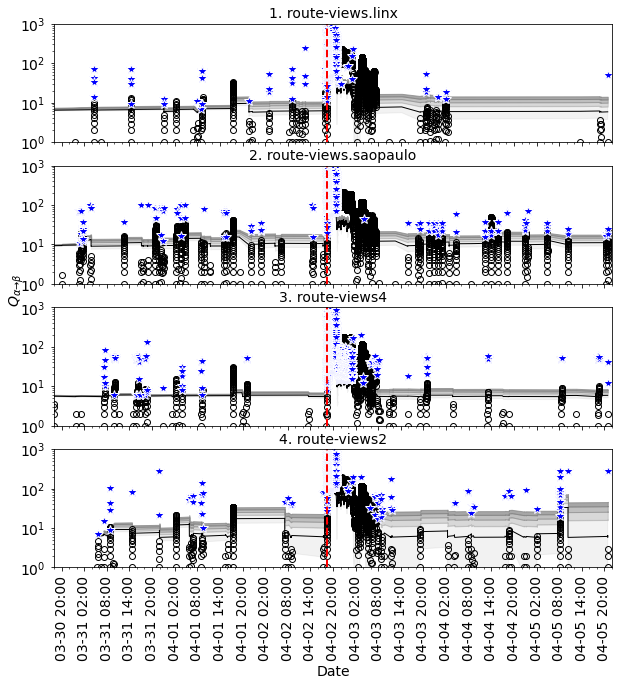

In [20]:
list_collectors = number_of_feeders[:4]

row = len(list_collectors)
col = 1

fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.2, wspace=0.05)

count = 0

for collector in list_collectors: #final_dic:
    
    print(collector)

    # print index_x, index_y
    ax = axes[count]
    ax.set_title(str(count + 1) + '. ' + collector, fontsize=14) 
    
    if dic[collector] != []:

        time_array = np.array(dic[collector])[:,0]

        q = 0
        r = 1/300 # 0.05, 0.01, 1/300 + 0.0033
        q_array = []
        delta_array = []

        for index in range(1, len(time_array)):
            delta = (time_array[index] - time_array[index-1]).seconds
            # print delta
            delta_array.append(delta)
            exponential_term = (2**(-r*delta))*q
            q = 1 + exponential_term
            q_array.append(q)

        # delta_array = np.array(delta_array)
        # print np.max(delta_array), np.min(delta_array)

        q_array = np.array(q_array)
        # print np.max(q_array), np.min(q_array)
        
        ax.plot(time_array[1:], q_array, linestyle="None", marker="o", mfc="None", markeredgecolor="black")
        ax.set_yscale("log")

        try: 
            
            LSTM_prediction = LSTM_predictor(time_array, q_array)
            x = time_array[5:]
            y = np.array(dic[collector])[:,1][5:]
            

            # print('rmse_LSTM: ', np.sqrt(mean_squared_error(y, LSTM_prediction)))

            s = pd.Series(LSTM_prediction, index=x)

            window_length = 200
            #mean = s.ewm(span=window_length, min_periods=1).mean()
            sd = s.ewm(span=window_length, min_periods=1).std()

            array_means = LSTM_prediction
            array_stds = sd.values

            ax.plot(x, array_means, color="black", linewidth=1.0)

            # Band scale
            sigma = 1.0
            ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="gray", alpha=0.10)

            ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="gray", alpha=0.30)
            # ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="gray", alpha=0.30)

            ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="gray", alpha=0.50)
            # ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="gray", alpha=0.50)

            ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="gray", alpha=0.70)
            # ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="gray", alpha=0.70)

            anomalies_index = (y >= (LSTM_prediction + 2*sigma*sd)).values

            # To avoid null cases
            if len(x[anomalies_index]) > 0:
                ax.plot(x[anomalies_index], y[anomalies_index], linestyle="None", marker="*", mfc="blue", markeredgecolor="white", markersize=10)  
        except:
            None
        
        # Assign font size
        for label in ([ax.xaxis.label, ax.yaxis.label]):
            label.set_fontsize(14)

        # x axis
        for tl in ax.get_xticklabels():
            tl.set_fontsize(14)
            tl.set_rotation(90)

        # y axis
        for tl in ax.get_yticklabels():
            tl.set_fontsize(14)

        # Change ticks space
        ax.tick_params(axis="both", which="major", pad=5)  


        # Setup the limit
        ax.set_xlim([datetime(2014, 3, 30, 18, 0, 0), datetime(2014, 4, 5, 22, 0, 0)])
        ax.set_ylim([10**0, 10**3])
        #ax.set_ylim(auto=True)
        #ax.set_ylim(bottom=1)

        ax.xaxis.set_major_locator(HourLocator(byhour=None, interval=6, tz=None))
        ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
        ax.xaxis.set_minor_locator(HourLocator(byhour=None, interval=2, tz=None))

        # Draw ground truth
    
        ax.axvline(datetime(2014, 4, 2, 18, 26, 0), color='red', linewidth=2.0, linestyle='--')
        # ax.axvline(datetime(2014, 4, 2, 21, 26, 0), color='red', linewidth=2.0, linestyle='--')

#         if collector in ground_truth_dic:
#             for line in ground_truth_dic[collector]:
#                 ax.axvline(line, color='red', linewidth=2.0, linestyle='--')

    count += 1
    
# plt.xticks(rotation=90)
# fig.autofmt_xdate(rotation=90) 
    

fig.text(0.49, -0.020, 'Date', va="center", rotation="horizontal", fontsize=14) # 0.5, 0.055
fig.text(0.06, 0.51, r'$Q_{\alpha \to \beta}$', va="center", rotation="vertical", fontsize=14) # 0.05, 0.55


# fit subplots and save fig
size = 10
fig.set_size_inches(w=size, h=1.0*size) # size/1.618

if len(list_collectors) % 2 != 0:
    ax = axes[int(len(list_collectors)/2), 1]
    ax.set_visible(False)


plt.show()

## Q Series Remaning Collectors

route-views.eqix
rmse:  21.23325127940798
route-views6
rmse:  9.157590624490467
route-views.isc
rmse:  22.81821917844329
route-views3
rmse:  22.167363526794265
route-views.sydney
rmse:  13.418482445239324
route-views.jinx
rmse:  2.7057163372594846
route-views.telxatl
rmse:  21.08900858578291
route-views.nwax
rmse:  19.38978933533086
route-views.wide
rmse:  18.722734038855013
route-views.perth
route-views.kixp
route-views.soxrs
rmse:  0.4658103348278089


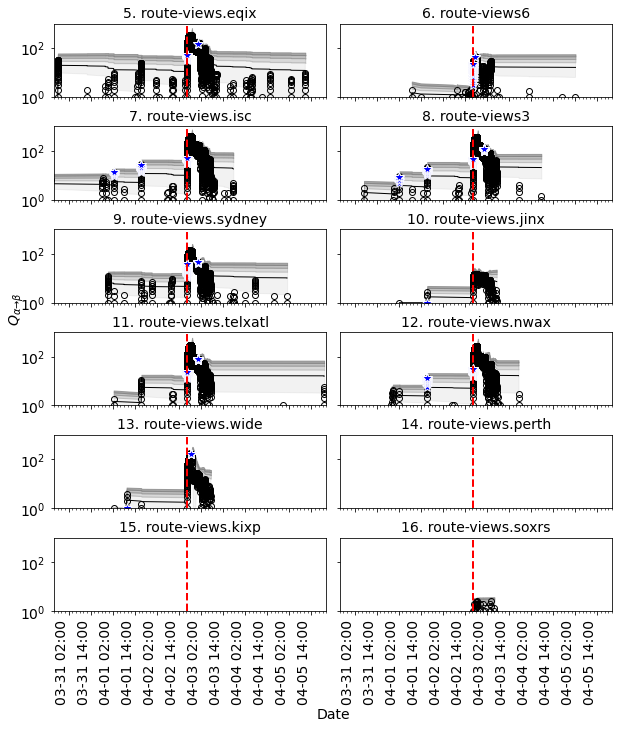

In [21]:
list_collectors = number_of_feeders[4:]

if len(list_collectors) % 2 != 0: # Odd
    row = int(len(list_collectors)/2) + 1
else: # Even
    row = int(len(list_collectors)/2)
col = 2

fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.4, wspace=0.05)

count = 0

for collector in list_collectors: #final_dic:
    
    print(collector)

    index_x = int(count/2)
    if count % 2 == 0:
        index_y = 0
    else:
        index_y = 1

    # print index_x, index_y
    ax = axes[index_x, index_y] 
    ax.set_title(str(count + 5) + '. ' + collector, fontsize=14) 
    
    if dic[collector] != []:

        time_array = np.array(dic[collector])[:,0]

        q = 0
        r = 1/300 # 0.05, 0.01
        q_array = []
        delta_array = []

        for index in range(1, len(time_array)):
            delta = (time_array[index] - time_array[index-1]).seconds
            # print delta
            delta_array.append(delta)
            exponential_term = (2**(-r*delta))*q
            q = 1 + exponential_term
            q_array.append(q)

        delta_array = np.array(delta_array)
        # print np.max(delta_array), np.min(delta_array)

        q_array = np.array(q_array)
        # print np.max(q_array), np.min(q_array)


        # print len(time_array[1:])
        s = pd.Series(q_array, index=time_array[1:])
        
        window_length = 200
        mean = s.ewm(span=window_length, min_periods=1).mean()
        sd = s.ewm(span=window_length, min_periods=1).std()

        x = s.index.to_pydatetime()
        y = s.values

        array_means = mean.values
        array_stds = sd.values

        #ax.plot(x, y, color='black')
        ax.plot(x, y, linestyle="None", marker="o", mfc="None", markeredgecolor="black")
        ax.set_yscale("log")

        
        ax.plot(x, array_means, color="black", linewidth=1.0)
        print('rmse: ', np.sqrt(mean_squared_error(y, array_means)))

        # Band scale
        sigma = 1.0
        ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="gray", alpha=0.10)

        ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="gray", alpha=0.30)
        # ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="gray", alpha=0.30)

        ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="gray", alpha=0.50)
        # ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="gray", alpha=0.50)

        ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="gray", alpha=0.70)
        # ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="gray", alpha=0.70)

        anomalies_index = y >= (mean + 2*sigma*sd)
        # print anomalies_index
        # print 'stars: ', x[anomalies_index], y[anomalies_index], 
        ax.plot(x[anomalies_index], y[anomalies_index], linestyle="None", marker="*", mfc="blue", markeredgecolor="white", markersize=10)  

    # Assign font size
    for label in ([ax.xaxis.label, ax.yaxis.label]):
        label.set_fontsize(14)

    # x axis
    for tl in ax.get_xticklabels():
        tl.set_fontsize(14)

    # y axis
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    # Change ticks space
    ax.tick_params(axis="both", which="major", pad=5)  

    # Setup the limit
    ax.set_xlim([datetime(2014, 3, 30, 18, 0, 0), datetime(2014, 4, 5, 22, 0, 0)])
    ax.set_ylim([10**0, 10**3])
    #ax.set_ylim(auto=True)
    #ax.set_ylim(bottom=1)

    ax.xaxis.set_major_locator(HourLocator(byhour=None, interval=12, tz=None))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
    ax.xaxis.set_minor_locator(HourLocator(byhour=None, interval=2, tz=None))
    ax.axvline(x=datetime(2014, 4, 2, 18, 26, 0), color='red', linestyle='--', linewidth=2.0)
        
    count += 1
    
fig.autofmt_xdate(rotation=90) 
    

fig.text(0.49, 0.08, 'Date', va="center", rotation="horizontal", fontsize=14)
fig.text(0.06, 0.55, r'$Q_{\alpha \to \beta}$', va="center", rotation="vertical", fontsize=14)

# fit subplots and save fig
size = 10
fig.set_size_inches(w=size, h=1.2*size) # size/1.618

if len(list_collectors) % 2 != 0:
    ax = axes[int(len(list_collectors)/2), 1]
    ax.set_visible(False)

plt.show()

## Q Series Remaining Collectors LSTM

route-views.eqix
Train Score: 8.00 RMSE
Test Score: 154.94 RMSE
route-views6
route-views.isc
Train Score: 1.23 RMSE
Test Score: 243.18 RMSE
route-views3
Train Score: 2.64 RMSE
Test Score: 236.25 RMSE
route-views.sydney
Train Score: 3.20 RMSE
Test Score: 86.91 RMSE
route-views.jinx
Train Score: 0.58 RMSE
Test Score: 7.47 RMSE
route-views.telxatl
Train Score: 0.00 RMSE
Test Score: 160.87 RMSE
route-views.nwax
Train Score: 3.41 RMSE
Test Score: 163.32 RMSE
route-views.wide
Train Score: 1.03 RMSE
Test Score: 111.73 RMSE
route-views.perth
route-views.kixp
route-views.soxrs


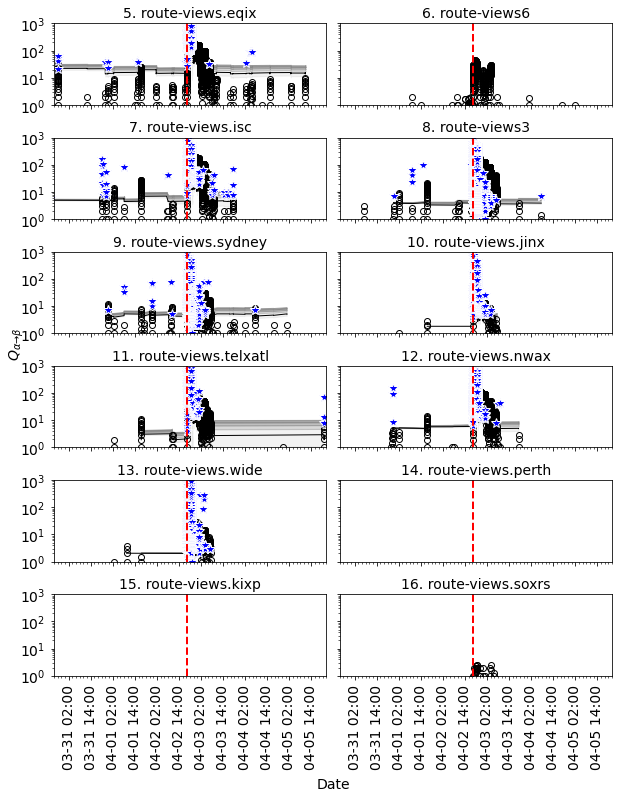

In [22]:
list_collectors = number_of_feeders[4:]

if len(list_collectors) % 2 != 0: # Odd
    row = int(len(list_collectors)/2) + 1
else: # Even
    row = int(len(list_collectors)/2)
col = 2

fig, axes = plt.subplots(row, col, sharex=True, sharey=True) 
fig.subplots_adjust(hspace=0.4, wspace=0.05)

count = 0

for collector in list_collectors: #final_dic:
    
    print(collector)

    index_x = int(count/2)
    if count % 2 == 0:
        index_y = 0
    else:
        index_y = 1

    # print index_x, index_y
    ax = axes[index_x, index_y] 
    ax.set_title(str(count + 5) + '. ' + collector, fontsize=14) 
    
    if dic[collector] != []:

        time_array = np.array(dic[collector])[:,0]

        q = 0
        r = 1/300 # 0.05, 0.01
        q_array = []
        delta_array = []

        for index in range(1, len(time_array)):
            delta = (time_array[index] - time_array[index-1]).seconds
            # print delta
            delta_array.append(delta)
            exponential_term = (2**(-r*delta))*q
            q = 1 + exponential_term
            q_array.append(q)

        delta_array = np.array(delta_array)
        # print np.max(delta_array), np.min(delta_array)

        q_array = np.array(q_array)
        # print np.max(q_array), np.min(q_array)
        
        ax.plot(time_array[1:], q_array, linestyle="None", marker="o", mfc="None", markeredgecolor="black")
        ax.set_yscale("log")


        try: 
            
            LSTM_prediction = LSTM_predictor(time_array, q_array)
            x = time_array[5:]
            y = np.array(dic[collector])[:,1][5:]
            
            # print('rmse_LSTM: ', np.sqrt(mean_squared_error(y, LSTM_prediction)))

            s = pd.Series(LSTM_prediction, index=x)

            window_length = 200
            #mean = s.ewm(span=window_length, min_periods=1).mean()
            sd = s.ewm(span=window_length, min_periods=1).std()

            array_means = LSTM_prediction
            array_stds = sd.values

            ax.plot(x, array_means, color="black", linewidth=1.0)

            # Band scale
            sigma = 1.0
            ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="gray", alpha=0.10)

            ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="gray", alpha=0.30)
            # ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="gray", alpha=0.30)

            ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="gray", alpha=0.50)
            # ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="gray", alpha=0.50)

            ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="gray", alpha=0.70)
            # ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="gray", alpha=0.70)

            anomalies_index = (y >= (LSTM_prediction + 2*sigma*sd)).values

            # To avoid null cases
            if len(x[anomalies_index]) > 0:
                ax.plot(x[anomalies_index], y[anomalies_index], linestyle="None", marker="*", mfc="blue", markeredgecolor="white", markersize=10)  
        except:
            None
        
    # Assign font size
    for label in ([ax.xaxis.label, ax.yaxis.label]):
        label.set_fontsize(14)

    # x axis
    for tl in ax.get_xticklabels():
        tl.set_fontsize(14)
        tl.set_rotation(90)

    # y axis
    for tl in ax.get_yticklabels():
        tl.set_fontsize(14)

    # Change ticks space
    ax.tick_params(axis="both", which="major", pad=5)  

    # Setup the limit
    ax.set_xlim([datetime(2014, 3, 30, 18, 0, 0), datetime(2014, 4, 5, 22, 0, 0)])
    ax.set_ylim([10**0, 10**3])
    #ax.set_ylim(auto=True)
    #ax.set_ylim(bottom=1)

    ax.xaxis.set_major_locator(HourLocator(byhour=None, interval=12, tz=None))
    ax.xaxis.set_major_formatter(DateFormatter("%m-%d %H:%M"))
    ax.xaxis.set_minor_locator(HourLocator(byhour=None, interval=2, tz=None))

    # Draw ground truth
    
    ax.axvline(datetime(2014, 4, 2, 18, 26, 0), color='red', linewidth=2.0, linestyle='--')
    # ax.axvline(datetime(2014, 4, 2, 21, 26, 0), color='red', linewidth=2.0, linestyle='--')
    
#     if collector in ground_truth_dic:
#         for line in ground_truth_dic[collector]:
#             ax.axvline(line, color='red', linewidth=2.0, linestyle='--')
        
    count += 1
    
# fig.autofmt_xdate(rotation=90) 
    

fig.text(0.49, 0.00, 'Date', va="center", rotation="horizontal", fontsize=14)
fig.text(0.06, 0.51, r'$Q_{\alpha \to \beta}$', va="center", rotation="vertical", fontsize=14)


# fit subplots and save fig
size = 10
fig.set_size_inches(w=size, h=1.2*size) # size/1.618

if len(list_collectors) % 2 != 0:
    ax = axes[int(len(list_collectors)/2), 1]
    ax.set_visible(False)

plt.show()

## Performance Analysis

In [23]:
import helper_functions

## Ground truth
date_time_start = '2014-03-30 12:13:04' 
date_time_end = '2014-04-05 16:52:15' 

date_of_incident = ['2014-04-02 18:26:00']
dates_list = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in date_of_incident]


granularity = 3
print('granularity', granularity)

# Map the Ground truth
o = helper_functions.map_ground_truth_to_regular_espace(date_time_start, date_time_end, dates_list, granularity) 

list_collectors = number_of_feeders

for collector in list_collectors: #final_dic:
    
    print(collector)
    
    if dic[collector] != []:
    
        ############
        ## Q measure
        ############

        time_array = np.array(dic[collector])[:,0]

        q = 0
        r = 1/300 # 0.05, 0.01
        q_array = []
        delta_array = []

        for index in range(1, len(time_array)):
            delta = (time_array[index] - time_array[index-1]).seconds
            # print delta
            delta_array.append(delta)
            exponential_term = (2**(-r*delta))*q
            q = 1 + exponential_term
            q_array.append(q)

        delta_array = np.array(delta_array)
        # print np.max(delta_array), np.min(delta_array)

        q_array = np.array(q_array)
        # print np.max(q_array), np.min(q_array)
        
        # print len(time_array[1:])
        s = pd.Series(q_array, index=time_array[1:])

        window_length = 200
        mean = s.ewm(span=window_length, min_periods=1).mean()
        sd = s.ewm(span=window_length, min_periods=1).std()

        array_means = mean.values
        array_stds = sd.values
        
        # Based on Q measure
        o_prime_q = helper_functions.map_signal_to_regular_space_one_shot(time_array[1:], q_array, array_means, array_stds, date_time_start, date_time_end, granularity)
        # print o_prime_q, type(o_prime_q)
        
        
        ##############
        # Volume masure
        ###############
        
        x = np.array(dic[collector])[:,0]
        y = np.array(dic[collector])[:,1]
        
        # Convert data in time series for calculations
        s = pd.Series(y, index=x)

        window_length = 200
        mean = s.ewm(span=window_length, min_periods=1).mean()
        sd = s.ewm(span=window_length, min_periods=1).std()
        
        array_means = mean.values
        array_stds = sd.values

        # Based on volume measure
        o_prime_volume = helper_functions.map_signal_to_regular_space_one_shot(x, y, array_means, array_stds, date_time_start, date_time_end, granularity)
                
        ###################
        # ML features
        ###################

        precision = []
        recall = []
        false_positive_rate = []
        true_positive_rate = []
        f1_rate = []
        

        # Calculate metrics
        tp = np.dot(o, o_prime_q) 
        fp = np.dot(1-o, o_prime_q)
        tn = np.dot(1-o, 1-o_prime_q)
        fn = np.dot(o, 1-o_prime_q)
        pr = tp/(tp + fp)
        rc = tp/(tp + fn)
        fpr = fp/(fp + tn)
        tpr = tp/(tp + fn)
        f1 = 2*((pr*rc)/(pr+rc))

        precision.append(pr)
        recall.append(rc)
        false_positive_rate.append(fpr)
        true_positive_rate.append(tpr)
        f1_rate.append(f1)
        
        
        print('q: ', 'pr: ', precision, 're: ', recall, 'f1: ', f1_rate, 'fpr: ', false_positive_rate, 'tpr: ', true_positive_rate)
        
        #######################
        # volume based metric
        #######################

        precision_volume = []
        recall_volume = []
        false_positive_rate_volume = []
        true_positive_rate_volume = []
        f1_rate_volume = []

    
        # Calculate metrics
        tp = np.dot(o, o_prime_volume) 
        fp = np.dot(1-o, o_prime_volume)
        tn = np.dot(1-o, 1-o_prime_volume)
        fn = np.dot(o, 1-o_prime_volume)
        pr = tp/(tp + fp)
        rc = tp/(tp + fn)
        fpr = fp/(fp + tn)
        tpr = tp/(tp + fn)
        f1 = 2*((pr*rc)/(pr+rc))

        precision_volume.append(pr)
        recall_volume.append(rc)
        false_positive_rate_volume.append(fpr)
        true_positive_rate_volume.append(tpr)
        f1_rate_volume.append(f1)
        
        print('volume: ', 'pr: ', precision_volume, 're: ', recall_volume, 'f1: ', f1_rate_volume, 'fpr: ', false_positive_rate_volume, 'tpr: ', true_positive_rate_volume)

granularity 3
route-views.linx
q:  pr:  [0.25] re:  [1.0] f1:  [0.4] fpr:  [0.061224489795918366] tpr:  [1.0]
volume:  pr:  [0.06666666666666667] re:  [1.0] f1:  [0.125] fpr:  [0.2857142857142857] tpr:  [1.0]
route-views.saopaulo
q:  pr:  [0.25] re:  [1.0] f1:  [0.4] fpr:  [0.061224489795918366] tpr:  [1.0]
volume:  pr:  [0.037037037037037035] re:  [1.0] f1:  [0.07142857142857142] fpr:  [0.5306122448979592] tpr:  [1.0]
route-views4
q:  pr:  [0.3333333333333333] re:  [1.0] f1:  [0.5] fpr:  [0.04081632653061224] tpr:  [1.0]
volume:  pr:  [0.07142857142857142] re:  [1.0] f1:  [0.13333333333333333] fpr:  [0.2653061224489796] tpr:  [1.0]
route-views2


/Users/pmoriano/miniconda3/envs/bgp-burstiness37/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars


q:  pr:  [0.0] re:  [0.0] f1:  [nan] fpr:  [0.08163265306122448] tpr:  [0.0]
volume:  pr:  [0.058823529411764705] re:  [1.0] f1:  [0.1111111111111111] fpr:  [0.32653061224489793] tpr:  [1.0]
route-views.eqix
q:  pr:  [0.5] re:  [1.0] f1:  [0.6666666666666666] fpr:  [0.02040816326530612] tpr:  [1.0]
volume:  pr:  [0.1] re:  [1.0] f1:  [0.18181818181818182] fpr:  [0.1836734693877551] tpr:  [1.0]
route-views6
q:  pr:  [1.0] re:  [1.0] f1:  [1.0] fpr:  [0.0] tpr:  [1.0]
volume:  pr:  [0.3333333333333333] re:  [1.0] f1:  [0.5] fpr:  [0.04081632653061224] tpr:  [1.0]
route-views.isc
q:  pr:  [0.3333333333333333] re:  [1.0] f1:  [0.5] fpr:  [0.04081632653061224] tpr:  [1.0]
volume:  pr:  [0.1111111111111111] re:  [1.0] f1:  [0.19999999999999998] fpr:  [0.16326530612244897] tpr:  [1.0]
route-views3
q:  pr:  [0.25] re:  [1.0] f1:  [0.4] fpr:  [0.061224489795918366] tpr:  [1.0]
volume:  pr:  [0.125] re:  [1.0] f1:  [0.2222222222222222] fpr:  [0.14285714285714285] tpr:  [1.0]
route-views.sydney
q

/Users/pmoriano/miniconda3/envs/bgp-burstiness37/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in long_scalars


q:  pr:  [0.5] re:  [1.0] f1:  [0.6666666666666666] fpr:  [0.02040816326530612] tpr:  [1.0]
volume:  pr:  [0.16666666666666666] re:  [1.0] f1:  [0.2857142857142857] fpr:  [0.10204081632653061] tpr:  [1.0]
route-views.wide
q:  pr:  [0.0] re:  [0.0] f1:  [nan] fpr:  [0.02040816326530612] tpr:  [0.0]
volume:  pr:  [0.25] re:  [1.0] f1:  [0.4] fpr:  [0.061224489795918366] tpr:  [1.0]
route-views.perth
route-views.kixp
route-views.soxrs
q:  pr:  [nan] re:  [0.0] f1:  [nan] fpr:  [0.0] tpr:  [0.0]
volume:  pr:  [nan] re:  [0.0] f1:  [nan] fpr:  [0.0] tpr:  [0.0]


/Users/pmoriano/miniconda3/envs/bgp-burstiness37/lib/python3.7/site-packages/ipykernel_launcher.py:105: RuntimeWarning: invalid value encountered in double_scalars
/Users/pmoriano/miniconda3/envs/bgp-burstiness37/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in long_scalars
/Users/pmoriano/miniconda3/envs/bgp-burstiness37/lib/python3.7/site-packages/ipykernel_launcher.py:132: RuntimeWarning: invalid value encountered in long_scalars


## Performance LSTM

In [24]:
importlib.reload(helper_functions)

## Ground truth

date_time_start = '2014-03-30 12:13:04' # 12:13:04, 16:13:04, 18:00:00
date_time_end = '2014-04-05 16:52:15' # 16:52:15, 20:52:15, 22:00:00

date_of_incident = ['2014-04-02 18:26:00'] 
#date_of_incident = ['2014-04-02 18:26:00', '2014-04-02 21:26:00'] 

dates_list = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in date_of_incident]

# print dates_list

granularity = 3
print('granularity', granularity)

# Ground truth
o = helper_functions.map_ground_truth_to_regular_espace(date_time_start, date_time_end, dates_list, granularity) 
# print "Ground truth: ", o
print("Ground truth index: ", [index for index, value in enumerate(o) if value == 1])

list_collectors = number_of_feeders

for collector in list_collectors: #[0:1]: #final_dic:
    
    print(collector)
    
    if dic[collector] != []:
    
        ############
        ## Q measure
        ############

        time_array = np.array(dic[collector])[:,0]

        q = 0
        r = 1/300 # 0.05, 0.01
        q_array = []
        delta_array = []

        for index in range(1, len(time_array)):
            delta = (time_array[index] - time_array[index-1]).seconds
            # print delta
            delta_array.append(delta)
            exponential_term = (2**(-r*delta))*q
            q = 1 + exponential_term
            q_array.append(q)

        delta_array = np.array(delta_array)
        # print np.max(delta_array), np.min(delta_array)

        q_array = np.array(q_array)
        # print np.max(q_array), np.min(q_array)
        
        try: 
            
            LSTM_prediction = LSTM_predictor(time_array, q_array)
            x = time_array[5:]
            y = np.array(dic[collector])[:,1][5:]
            
            # print('rmse_LSTM: ', np.sqrt(mean_squared_error(y, LSTM_prediction)))

            s = pd.Series(LSTM_prediction, index=x)

            window_length = 200
            #mean = s.ewm(span=window_length, min_periods=1).mean()
            sd = s.ewm(span=window_length, min_periods=1).std()

            array_means = LSTM_prediction
            array_stds = sd.values
            
            #print(len(time_array[5:]), len(q_array[4:]), len(array_means), len(array_stds))
            
            # Based on Q measure
            o_prime_q = helper_functions.map_signal_to_regular_space_one_shot(time_array[5:], q_array[4:], array_means, array_stds, date_time_start, date_time_end, granularity)
            #print "o_prime_q: ", o_prime_q
            print("o_prime_q_lstm index: ", [index for index, value in enumerate(o_prime_q) if value == 1])
            
        except:
            None
        
#         # print len(time_array[1:])
#         s = pd.Series(q_array, index=time_array[1:])

#         window_length = 200
#         mean = s.ewm(span=window_length, min_periods=1).mean()
#         sd = s.ewm(span=window_length, min_periods=1).std()

#         array_means = mean.values
#         array_stds = sd.values
        
#         # Based on Q measure
#         o_prime_q = helper_functions.map_signal_to_regular_space_one_shot(time_array[1:], q_array, array_means, array_stds, date_time_start, date_time_end, granularity)
#         #print "o_prime_q: ", o_prime_q
#         print("o_prime_q index: ", [index for index, value in enumerate(o_prime_q) if value == 1])
        
        
        ##############
        # Volume measure
        ###############
        
        x = np.array(dic[collector])[:,0]
        y = np.array(dic[collector])[:,1]
        
        # Convert data in time series for calculations
        s = pd.Series(y, index=x)

        window_length = 200
        mean = s.ewm(span=window_length, min_periods=1).mean()
        sd = s.ewm(span=window_length, min_periods=1).std()
        
        array_means = mean.values
        array_stds = sd.values

        # Based on volume measure
        o_prime_volume = helper_functions.map_signal_to_regular_space_one_shot(x, y, array_means, array_stds, date_time_start, date_time_end, granularity)
        #print "o_prime_volume: ", o_prime_volume
        print("o_prime_volume index: ", [index for index, value in enumerate(o_prime_volume) if value == 1])
            
        ###################
        # ML features
        ###################

        precision = []
        recall = []
        false_positive_rate = []
        true_positive_rate = []
        f1_rate = []
        

        # Calculate metrics
        tp = np.dot(o, o_prime_q) 
        fp = np.dot(1-o, o_prime_q)
        tn = np.dot(1-o, 1-o_prime_q)
        fn = np.dot(o, 1-o_prime_q)
        pr = tp/(tp + fp + 1e-100)
        rc = tp/(tp + fn + 1e-100)
        fpr = fp/(fp + tn + 1e-100)
        tpr = tp/(tp + fn + 1e-100)
        f1 = 2*((pr*rc)/(pr+rc + 1e-100))

        precision.append(pr)
        recall.append(rc)
        false_positive_rate.append(fpr)
        true_positive_rate.append(tpr)
        f1_rate.append(f1)
        
        
        print('q_lstm: ', 'pr: ', precision, 're: ', recall, 'f1: ', f1_rate, 'fpr: ', false_positive_rate, 'tpr: ', true_positive_rate)
        
        #######################
        # volume based metric
        #######################

        precision_volume = []
        recall_volume = []
        false_positive_rate_volume = []
        true_positive_rate_volume = []
        f1_rate_volume = []

    
        # Calculate metrics
        tp = np.dot(o, o_prime_volume) 
        fp = np.dot(1-o, o_prime_volume)
        tn = np.dot(1-o, 1-o_prime_volume)
        fn = np.dot(o, 1-o_prime_volume)
        pr = tp/(tp + fp + 1e-100)
        rc = tp/(tp + fn + 1e-100)
        fpr = fp/(fp + tn + 1e-100)
        tpr = tp/(tp + fn + 1e-100)
        f1 = 2*((pr*rc)/(pr+rc + 1e-100))

        precision_volume.append(pr)
        recall_volume.append(rc)
        false_positive_rate_volume.append(fpr)
        true_positive_rate_volume.append(tpr)
        f1_rate_volume.append(f1)
        
        print('volume: ', 'pr: ', precision_volume, 're: ', recall_volume, 'f1: ', f1_rate_volume, 'fpr: ', false_positive_rate_volume, 'tpr: ', true_positive_rate_volume)
        print("\n")

granularity 3
Ground truth index:  [26]
route-views.linx
Train Score: 3.66 RMSE
Test Score: 256.27 RMSE
o_prime_q_lstm index:  [1, 5, 9, 13, 15, 18, 23, 26, 27, 28, 29, 30, 36, 37]
o_prime_volume index:  [5, 9, 15, 21, 23, 24, 26, 27, 28, 29, 30, 35, 36, 37, 49]
q_lstm:  pr:  [0.07142857142857142] re:  [1.0] f1:  [0.13333333333333333] fpr:  [0.2653061224489796] tpr:  [1.0]
volume:  pr:  [0.06666666666666667] re:  [1.0] f1:  [0.125] fpr:  [0.2857142857142857] tpr:  [1.0]


route-views.saopaulo
Train Score: 5.57 RMSE
Test Score: 193.18 RMSE
o_prime_q_lstm index:  [4, 8, 11, 13, 17, 18, 26, 27, 28, 29, 30, 35, 36, 41, 42, 44, 46, 49]
o_prime_volume index:  [4, 5, 10, 11, 12, 13, 15, 17, 20, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 40, 41, 42, 44, 46, 49]
q_lstm:  pr:  [0.05555555555555555] re:  [1.0] f1:  [0.10526315789473684] fpr:  [0.3469387755102041] tpr:  [1.0]
volume:  pr:  [0.037037037037037035] re:  [1.0] f1:  [0.07142857142857142] fpr:  [0.5306122448979592] tpr:  [1.0]


ro